# Combined Recent Surveys
This notebook make predictions for the combined features and cross border predictions.

In [1]:
cd ..

/Users/emmaboehly/Documents/Master1/Machine Learning/Projet2/MLProjet2/src


In [2]:
%autoreload 2
%load_ext autoreload
%matplotlib inline

UsageError: Line magic function `%autoreload` not found.


In [3]:
from lib import estimator_util as eu
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from tqdm import tqdm
from lib import clusters_utils as cl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
sns.set_theme()

In [5]:
complete_df, all_cols = eu.get_data("../data/lsms/processed/_all_real.csv", "../data/cnn_features/resnet_trans_all_countries_hyper.csv", "../data/")

In [6]:
countries = ["NG", "ETH", "TZA", "MW"]
X, _, _, _ = eu.get_recent_osm_features(complete_df, countries, all_cols)
X = pd.DataFrame(X, columns=all_cols)
null_features = X.loc[:, (X == 0).any(axis=0)].keys()

## Heatmap for cross country

In [7]:
def run_combined(df, osm_cols, model, **params) :
    countries = [["NG"], ["ETH"] ,["TZA"], ["MW"], ["NG", "ETH", "TZA", "MW"]]
    results = np.zeros((5,5))
    for i, country in enumerate(countries):
        X, y = eu.get_recent_features(df, country, osm_cols)
        for j, out_country in enumerate(countries):
            X_out, y_out = eu.get_recent_features(df, out_country, osm_cols)
            r, _, m = eu.run_model_out(X, y, X_out, y_out, model, **params)
            results[i,j] = r
    return results

In [16]:
def heatmap(data, name : string):
    countries = ["Nigeria", "Ethiopia" ,"Tanzania", "Malawi", "Pooled"]
    df_cm = pd.DataFrame(data, index = countries, columns = countries)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cbar_kws={'label': r'$r^2$'})
    plt.xlabel("Country trained on")
    plt.ylabel("Country evaluated on")
    plt.title("Heatmap of the cross country predictions with " + name)
    ax = plt.gca()
    plt.text(-0.1, 1.1, string.ascii_uppercase[0], size=20, weight='bold', transform=ax.transAxes)
    plt.savefig("../figs/cross_country_pooled_{name}.pdf", dpi=600, bbox_inches="tight")

### Using Ridge Regression to compare with the original model

In [17]:
ridge_results = run_combined(complete_df, all_cols, Ridge, alpha = 1000)

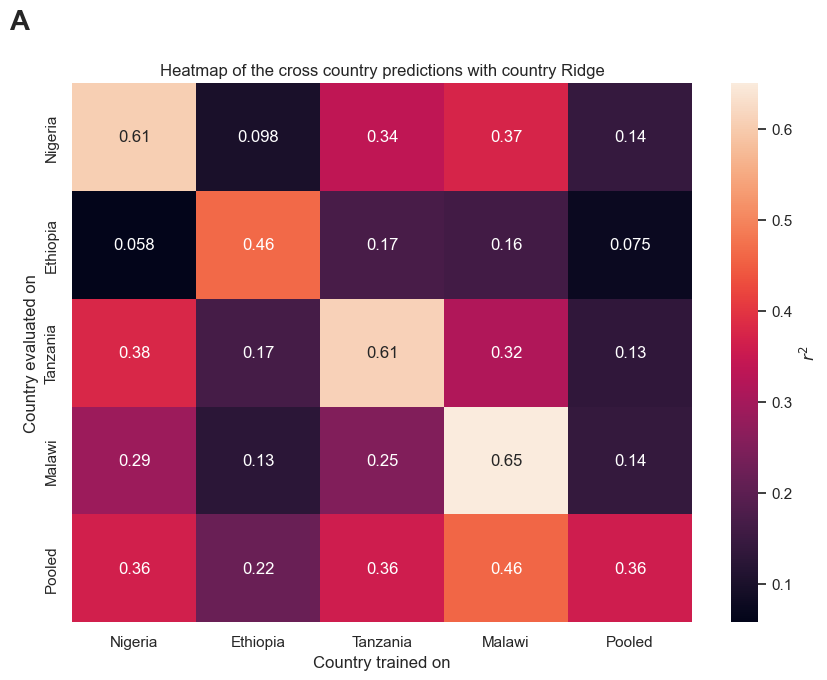

In [18]:
heatmap(ridge_results, "Ridge")

### Using CatBoost our best model

In [ ]:
catboost_results = run_combined(complete_df, all_cols, CatBoostRegressor, random_state=42)

In [ ]:
heatmap(catboost_results, "CatBoost")

## Pooled Dataset

In [11]:
def plot_pooled_results(df, osm_cols, model, **params) :
    years = df.groupby(["year"]).groups.keys()
    year = max(years)
    recent_df_complete = df.loc[df.year == year]
    split_map = cl.split_k_sets(10, lat=recent_df_complete["lat"], lon=recent_df_complete["lon"])
    X, y = eu.get_recent_features(df, ["NG", "ETH", "TZA", "MW"], osm_cols, null_osm_features=null_features)
    r2, y_real, y_predicted, trained_model = eu.run_model(X, y, model, seed=1, kf= cl.folds_from_split(split_map), **params)
    fig = eu.plot_predictions(y_real, y_predicted, r2, "Pooled", "max in Dataset")
    return fig, model


### with Ridge

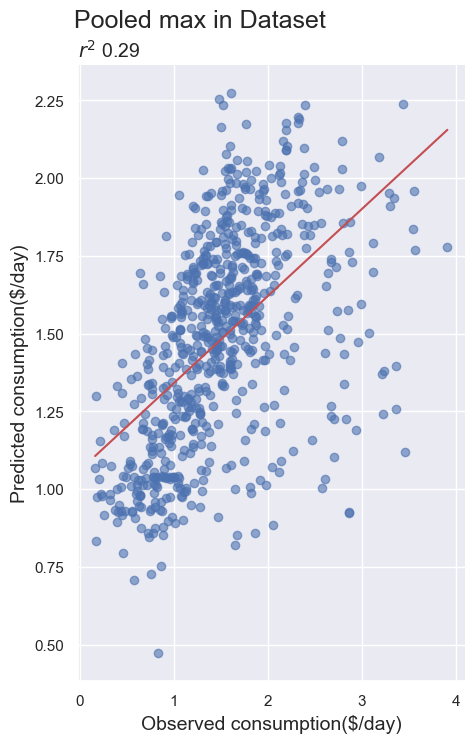

In [12]:
fig, _ = plot_pooled_results(complete_df, all_cols, Ridge, alpha = 1000)
fig.savefig("../figs/pooled_max_year_ridge.pdf", dpi=600, bbox_inches="tight")

### with CatBoost

In [ ]:
fig, model = plot_pooled_results(complete_df, all_cols, CatBoostRegressor, random_state=42)
fig.savefig("../figs/pooled_max_year_catboost.pdf", dpi=600, bbox_inches="tight")

In [ ]:
def features_importance(model) :
    importance = model.feature_importances_
    cnn_features_names = [f'cnn{i}' for i in range(len(complete_df.features[0]))]
    features_names = np.concatenate((all_cols, cnn_features_names))
    mask = ~pd.Series(features_names).str.match(r'^cnn')
    
    fig, ax = plt.subplots(figsize=(10, 20))
    sorted_importance, sorted_features = zip(*sorted(zip(importance[mask], features_names[mask])))
    #sorted_importance, sorted_features = importance[mask], features_names[mask]
    ax.barh(sorted_features, sorted_importance)
    ax.set_yticklabels(sorted_features, fontsize=6)
    
    plt.xlabel('Importance', fontsize=14)
    plt.title(f'Features importance for all country', fontsize=18)    
    plt.show()
    return fig

fig = features_importance(model)
fig.savefig("../figs/features_importance_combined_catboost.pdf", dpi=600, bbox_inches="tight")


NameError: name 'model' is not defined